## 0. Define function

In [60]:
import trimesh
import numpy as np

import os
import numpy as np
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from scipy.spatial.transform import Rotation as R
import time
import pickle
import argparse
from utils import *
import matplotlib 
from matplotlib import pyplot as plt
from tqdm import tqdm
from deepVCP import DeepVCP
from deepVCP_loss import get_rigid_transform 
import open3d as o3d
import copy

In [2]:
src_pts = trimesh.load('./meshes/bun000_v2.ply')

In [3]:
def cal_boundinbox_len(model):
    x_len = np.amax(model[:,0]) - np.amin(model[:,0])
    y_len = np.amax(model[:,1]) - np.amin(model[:,1])
    z_len = np.amax(model[:,2]) - np.amin(model[:,2])
    diag_len_bounding_box = np.sqrt(x_len * x_len + y_len * y_len + z_len * z_len)
    return diag_len_bounding_box

In [4]:
def generate_G_t(model, diag_len_bounding_box):
    theta_x = np.random.uniform(0, np.pi/5)
    theta_y = np.random.uniform(0, np.pi/5)
    theta_z = np.random.uniform(0, np.pi/5)
    
    # generate random translation
    translation_max = diag_len_bounding_box * 0.3
    translation_min = diag_len_bounding_box  * 0.3
    t = np.random.uniform(translation_min, translation_max, (3, 1))
    Rx = RotX(theta_x)
    Ry = RotY(theta_y)
    Rz = RotZ(theta_z)
    R = Rx @ Ry @ Rz
    target_points = R @ model.T + t
    return target_points, R, t

In [5]:
def display2(inputs, str = None):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    colors=['b','r']
    for idx, input in enumerate(inputs):
        ax.scatter(input[:,0], input[:,1], -input[:,2], c=colors[idx], marker='.', s=1)
    if str is not None:
        plt.title(str)
    plt.show()

In [6]:
def calculate_mse(img1, img2):
    mse = np.mean((np.array(img1, dtype=np.float32) - np.array(img2, dtype=np.float32)) ** 2)
    return  mse

In [7]:
def build_trans_matrix(R, t):
    trans_matrix = np.zeros(shape = (4, 4))
    trans_matrix[:3, :3] = R
    trans_matrix[:3, 3] = t.flatten()
    trans_matrix[3, 3] = 1
    return trans_matrix

## 1. Visualise test result

In [8]:
src = src_pts.sample(10000)
boundingbox_len = cal_boundinbox_len(src)
targets, R, t = generate_G_t(src, boundingbox_len)

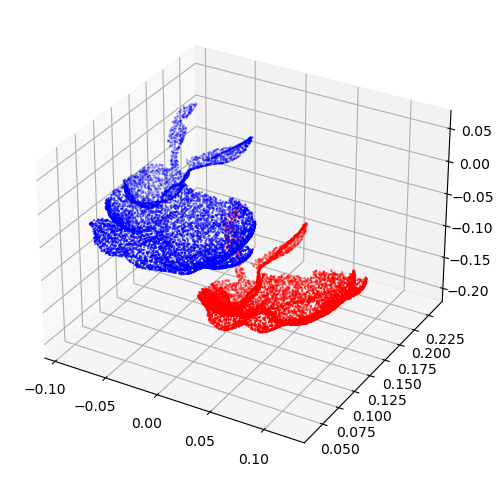

In [9]:
display2([src, targets.T])

In [20]:
R_prior = R.copy()
bias = np.pi/6
theta_x = np.random.uniform(-bias, bias)
theta_y = np.random.uniform(-bias, bias)
theta_z = np.random.uniform(-bias, bias)
Rx = RotX(theta_x)
Ry = RotY(theta_y)
Rz = RotZ(theta_z)
R_noise = Rx @ Ry @ Rz
R_prior = R_prior @ R_noise
t_init =  torch.randn((1, 3)).cuda()

In [21]:
trans_true = build_trans_matrix(R, t)
trans_prior = build_trans_matrix(R_prior, t_init.cpu().numpy())

In [22]:
deepvcp_model = DeepVCP(use_normal=False).cuda()
deepvcp_model.load_state_dict(torch.load('epoch_17_model.pt', map_location='cuda'))

<All keys matched successfully>

In [23]:
R_prior = torch.from_numpy(R_prior).cuda()#.unsqueeze(0)
src_xyz = torch.from_numpy(src.T).unsqueeze(0).cuda()
target_xyz = torch.from_numpy(targets).unsqueeze(0).cuda()
deepvcp_model.eval()
with torch.no_grad():
    src_keypts, target_vcp = deepvcp_model(src_xyz, target_xyz, R_prior, t_init)

feature extraction time:  17.103817462921143
src_keypts_idx_unsqueezed:  torch.Size([1, 3, 64])
src_keypts:  torch.Size([1, 64, 3])
Grouping keypoints time:  0.03488326072692871
B:  1
K_topk:  64
nsample:  32
num_feat:  32
get_cat_feat_src time:  0.0009970664978027344
tgt_pts_xyz:  torch.Size([1, 10000, 3])
ref_pts:  torch.Size([1, 10000, 3])
dist_normalize:  torch.Size([1, 32, 13824])
feat_weight_map:  torch.Size([1, 32, 32, 13824])
idx_1_mask:  tensor([[0]])
idx_1_mask_flatten:  tensor([0])
idx_2_mask:  tensor([9204, 4700, 8448,  ..., 9170, 5927, 8935], device='cuda:0')
get_cat_feat_tgt time:  0.10265684127807617


In [24]:
R_pred, t_pred = get_rigid_transform(src_keypts.permute(0,2,1).float(), target_vcp.permute(0,2,1).float())

In [25]:
src_t = torch.matmul(R_pred, src_xyz.float()) + t_pred
src_t = src_t.permute(0,2,1).cpu().numpy()[0].astype(np.float64)
z = np.array(targets.T)
org = (R_prior@src_xyz[0]).T.cpu().numpy()

c:\Users\bingwang\.conda\envs\3D2\lib\site-packages\matplotlib\collections.py:981: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Text(0.5, 1.0, 'DeepVCP result')

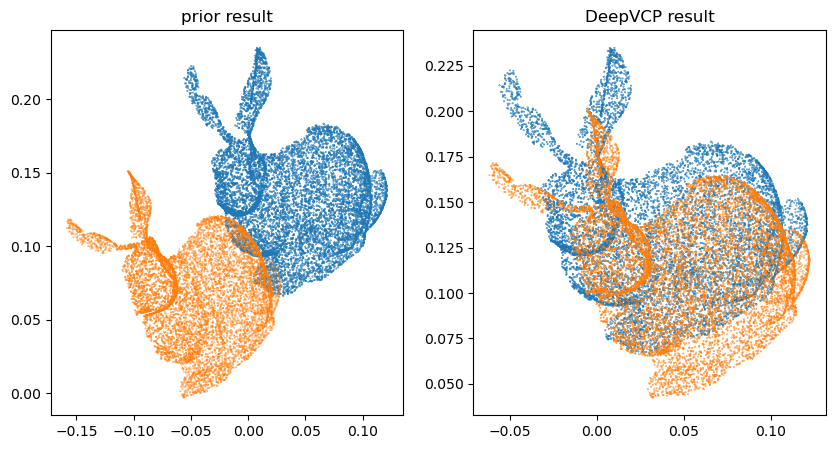

In [26]:
plt.figure(figsize=(10.0, 5.0))
plt.subplot(1, 2, 1)
plt.scatter(z[:,0], z[:,1], z[:,2])
plt.scatter(org[:,0], org[:,1], org[:,2])
plt.title('prior result')

plt.subplot(1, 2, 2)
plt.scatter(z[:,0], z[:,1], z[:,2])
plt.scatter(src_t[:,0], src_t[:,1], src_t[:,2])
plt.title('DeepVCP result')


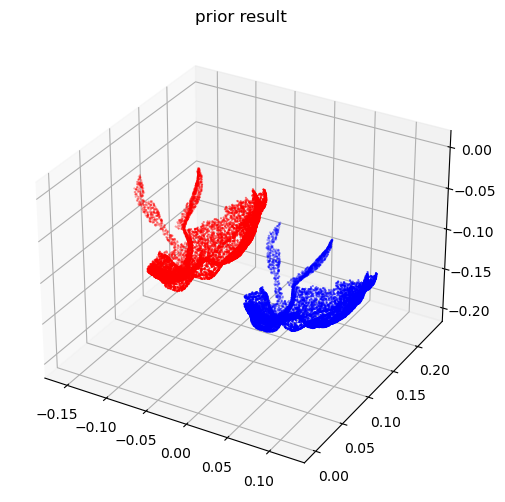

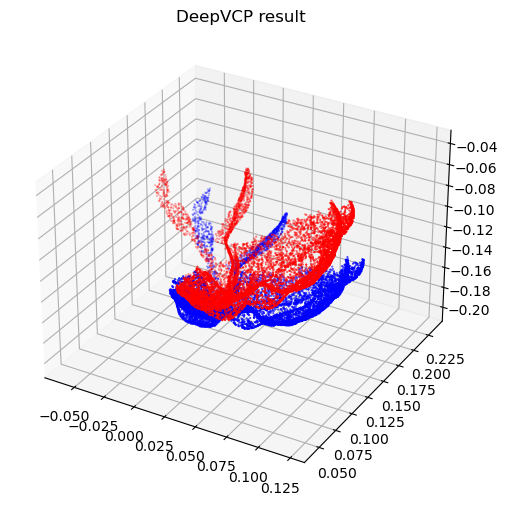

In [27]:
display2([z, org], str = 'prior result')
display2([z, src_t], str = 'DeepVCP result')

In [28]:
trans_pred = build_trans_matrix(R_pred.cpu().numpy(), t_pred.cpu().numpy())
print('MSE error:', calculate_mse(trans_true, trans_pred))

MSE error: 0.02016633


## 2. Compare with ICP

In [29]:
trans_init = trans_prior.copy()

In [30]:
no_trans = np.eye(4,4)
# trans_init = no_trans

In [31]:
src_pcd = o3d.geometry.PointCloud()
src_pcd.points = o3d.utility.Vector3dVector(src_pts.vertices)
target_pcd = o3d.geometry.PointCloud()
target_pcd.points = o3d.utility.Vector3dVector(targets.T)
reg_p2p = o3d.pipelines.registration.registration_icp(
    src_pcd, target_pcd, 5.5, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint())

reg_p2p_comb = o3d.pipelines.registration.registration_icp(
    src_pcd, target_pcd, 5.5, trans_pred,
    o3d.pipelines.registration.TransformationEstimationPointToPoint())

In [32]:
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])

In [38]:
draw_registration_result(src_pcd, target_pcd, reg_p2p.transformation)

In [37]:
draw_registration_result(src_pcd, target_pcd, trans_pred)

In [36]:
draw_registration_result(src_pcd, target_pcd, reg_p2p_comb.transformation)

## 3. Global registration

### a. load data

In [39]:
bunny_000 = trimesh.load('./meshes/bun000_v2.ply')
bunny_045 = trimesh.load('./meshes/bun045_v2.ply')
bunny_090 = trimesh.load('./meshes/bun090_v2.ply')
bunny_180 = trimesh.load('./meshes/bun180_v2.ply')
bunny_270 = trimesh.load('./meshes/bun270_v2.ply')
bunny_315 = trimesh.load('./meshes/bun315_v2.ply')

In [40]:
MODEL_dict = {'bunny_000' : bunny_000, 'bunny_045' : bunny_045, 'bunny_090': bunny_090, 
              'bunny_180': bunny_180, 'bunny_270': bunny_270, 'bunny_315':bunny_315}

In [41]:
print(MODEL_dict.keys())

dict_keys(['bunny_000', 'bunny_045', 'bunny_090', 'bunny_180', 'bunny_270', 'bunny_315'])


In [56]:
MODEL_dict['bunny_090'].show()

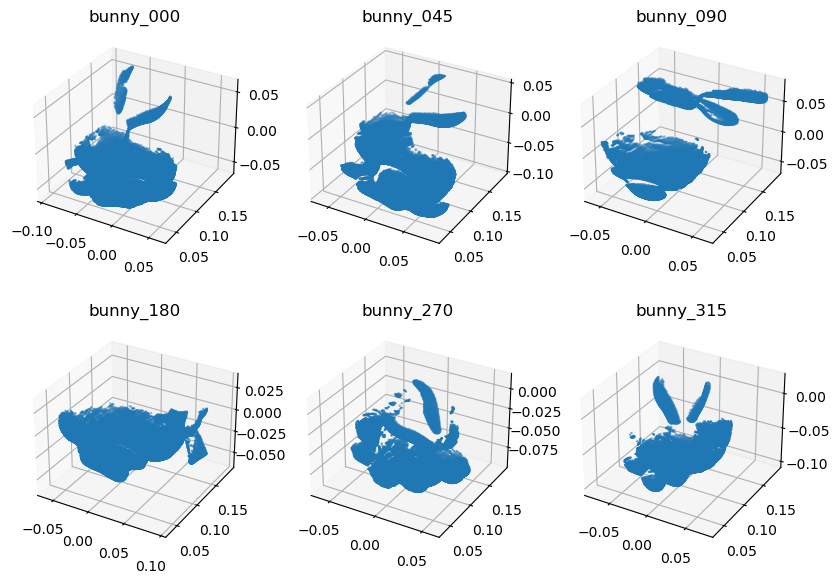

In [42]:
fig = plt.figure(figsize = (10.0, 7.0))
N_model = len(MODEL_dict)
for idx, key in enumerate(MODEL_dict):
    model = MODEL_dict[key]
    ax = fig.add_subplot(2, (N_model - 1) // 2 + 1, idx + 1, projection='3d')
    input = model.vertices
    ax.scatter(input[:,0], input[:,1], -input[:,2], marker='.', s=1)
    ax.set_title(key)

### b. global registration

In [89]:
def apply_DeepVCP(src_pts, targets_pts, R_prior = None):
    indices = np.random.choice(src_pts.shape[0], 10000)
    src = src_pts[indices]
    indices = np.random.choice(src_pts.shape[0], 10000)
    targets = targets_pts[indices]
    src_xyz = torch.from_numpy(src.T).unsqueeze(0).cuda()
    target_xyz = torch.from_numpy(targets.T).unsqueeze(0).cuda()
    deepvcp_model.eval()

    if R_prior is None:
        R_prior = np.eye(3, 3)
    else:
        R_prior = R.from_euler('y', R_prior, degrees=True).as_matrix()

    R_prior = torch.from_numpy(R_prior).cuda()

    with torch.no_grad():
        src_keypts, target_vcp = deepvcp_model(src_xyz, target_xyz, R_prior, t_init)
    R_pred, t_pred = get_rigid_transform(src_keypts.permute(0,2,1).float(), target_vcp.permute(0,2,1).float())
    trans_pred = build_trans_matrix(R_pred.cpu().numpy(), t_pred.cpu().numpy())
    return trans_pred, R_pred.cpu().numpy(), t_pred.cpu().numpy()

In [84]:
R_prior = R.from_euler('y', -45, degrees=True).as_matrix()

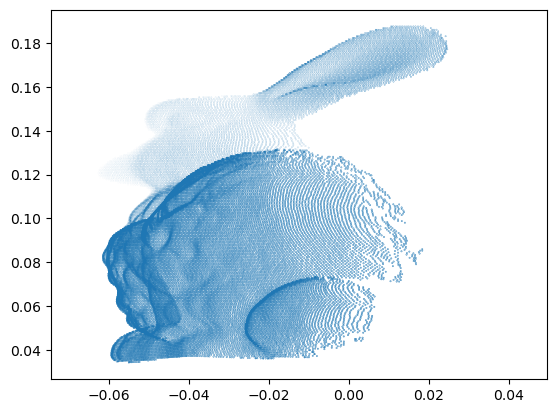

In [85]:
e = (R_prior@MODEL_dict['bunny_045'].vertices.T).T
plt.scatter(e[:,0], e[:,1], e[:,2])

In [134]:
global_model = MODEL_dict['bunny_000'].vertices
prior = [30, 90, 180, 270, 315]
for idx, key in tqdm(enumerate(MODEL_dict)):
    print(key)
    model = MODEL_dict[key].vertices
    if idx == 0:
        global_model = model
        continue
    trans_pred_tmp, R_tmp, t_tmp = apply_DeepVCP(model, global_model, prior[idx-1])
    align_model = (R_tmp@model.T).T + t_tmp
    global_model = np.concatenate((global_model, align_model.squeeze()), axis=0)

0it [00:00, ?it/s]

bunny_000
bunny_045
feature extraction time:  6.448668718338013
src_keypts_idx_unsqueezed:  torch.Size([1, 3, 64])
src_keypts:  torch.Size([1, 64, 3])
Grouping keypoints time:  0.01793980598449707
B:  1
K_topk:  64
nsample:  32
num_feat:  32
get_cat_feat_src time:  0.0


2it [00:12,  6.46s/it]

tgt_pts_xyz:  torch.Size([1, 10000, 3])
ref_pts:  torch.Size([1, 10000, 3])
dist_normalize:  torch.Size([1, 32, 13824])
feat_weight_map:  torch.Size([1, 32, 32, 13824])
idx_1_mask:  tensor([[0]])
idx_1_mask_flatten:  tensor([0])
idx_2_mask:  tensor([9622, 6562, 4236,  ..., 9608, 5564,  873], device='cuda:0')
get_cat_feat_tgt time:  0.09169340133666992
bunny_090
feature extraction time:  6.24112606048584
src_keypts_idx_unsqueezed:  torch.Size([1, 3, 64])
src_keypts:  torch.Size([1, 64, 3])
Grouping keypoints time:  0.017940044403076172
B:  1
K_topk:  64
nsample:  32
num_feat:  32
get_cat_feat_src time:  0.0009965896606445312


3it [00:25,  9.08s/it]

tgt_pts_xyz:  torch.Size([1, 10000, 3])
ref_pts:  torch.Size([1, 10000, 3])
dist_normalize:  torch.Size([1, 32, 13824])
feat_weight_map:  torch.Size([1, 32, 32, 13824])
idx_1_mask:  tensor([[0]])
idx_1_mask_flatten:  tensor([0])
idx_2_mask:  tensor([6986, 2762, 2878,  ..., 1547, 6659, 5452], device='cuda:0')
get_cat_feat_tgt time:  0.07873749732971191
bunny_180
feature extraction time:  6.4446306228637695
src_keypts_idx_unsqueezed:  torch.Size([1, 3, 64])
src_keypts:  torch.Size([1, 64, 3])
Grouping keypoints time:  0.01793956756591797
B:  1
K_topk:  64
nsample:  32
num_feat:  32
get_cat_feat_src time:  0.0


4it [00:38, 10.52s/it]

tgt_pts_xyz:  torch.Size([1, 10000, 3])
ref_pts:  torch.Size([1, 10000, 3])
dist_normalize:  torch.Size([1, 32, 13824])
feat_weight_map:  torch.Size([1, 32, 32, 13824])
idx_1_mask:  tensor([[0]])
idx_1_mask_flatten:  tensor([0])
idx_2_mask:  tensor([9565, 4161, 2141,  ..., 3787, 8102, 5984], device='cuda:0')
get_cat_feat_tgt time:  0.08571362495422363
bunny_270
feature extraction time:  6.225271701812744
src_keypts_idx_unsqueezed:  torch.Size([1, 3, 64])
src_keypts:  torch.Size([1, 64, 3])
Grouping keypoints time:  0.018936872482299805
B:  1
K_topk:  64
nsample:  32
num_feat:  32
get_cat_feat_src time:  0.0


5it [00:51, 11.34s/it]

tgt_pts_xyz:  torch.Size([1, 10000, 3])
ref_pts:  torch.Size([1, 10000, 3])
dist_normalize:  torch.Size([1, 32, 13824])
feat_weight_map:  torch.Size([1, 32, 32, 13824])
idx_1_mask:  tensor([[0]])
idx_1_mask_flatten:  tensor([0])
idx_2_mask:  tensor([5427, 3730, 1719,  ...,  147, 8296, 9742], device='cuda:0')
get_cat_feat_tgt time:  0.08283877372741699
bunny_315
feature extraction time:  6.441600322723389
src_keypts_idx_unsqueezed:  torch.Size([1, 3, 64])
src_keypts:  torch.Size([1, 64, 3])
Grouping keypoints time:  0.017940044403076172
B:  1
K_topk:  64
nsample:  32
num_feat:  32
get_cat_feat_src time:  0.0


6it [01:04, 10.76s/it]

tgt_pts_xyz:  torch.Size([1, 10000, 3])
ref_pts:  torch.Size([1, 10000, 3])
dist_normalize:  torch.Size([1, 32, 13824])
feat_weight_map:  torch.Size([1, 32, 32, 13824])
idx_1_mask:  tensor([[0]])
idx_1_mask_flatten:  tensor([0])
idx_2_mask:  tensor([4632, 6979, 6806,  ..., 7700, 3874,  361], device='cuda:0')
get_cat_feat_tgt time:  0.08371996879577637


In [138]:
global_model_pcd = o3d.geometry.PointCloud()
global_model_pcd.points = o3d.utility.Vector3dVector(global_model)
o3d.visualization.draw_geometries([global_model_pcd])

c:\Users\bingwang\.conda\envs\3D2\lib\site-packages\matplotlib\collections.py:981: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


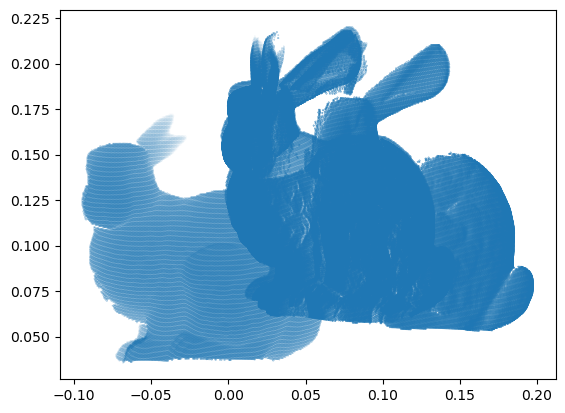

In [93]:
plt.scatter(global_model[:,0], global_model[:,1], global_model[:,2])

c:\Users\bingwang\.conda\envs\3D2\lib\site-packages\matplotlib\collections.py:981: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


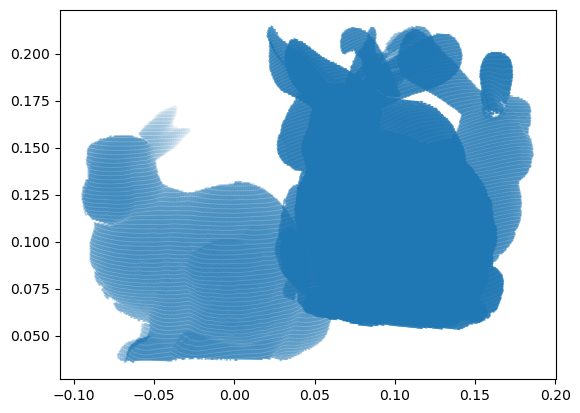

In [49]:
plt.scatter(global_model[:,0], global_model[:,1], global_model[:,2])

ICP global

In [129]:
global_model_ICP = MODEL_dict['bunny_000'].vertices
prior = [None, 90, 180, 270, 315]
for idx, key in tqdm(enumerate(MODEL_dict)):
    print(key)
    model = MODEL_dict[key].vertices
    if idx == 0:
        global_model_ICP = model
        continue

    trans_init = np.eye(4, 4)
    trans_init[:3,:3] = R.from_euler('y', prior[idx-1], degrees=True).as_matrix()
    src_pcd = o3d.geometry.PointCloud()
    src_pcd.points = o3d.utility.Vector3dVector(model)
    target_pcd = o3d.geometry.PointCloud()
    target_pcd.points = o3d.utility.Vector3dVector(global_model_ICP)
    
    reg_p2p_tmp = o3d.pipelines.registration.registration_icp(
        src_pcd, target_pcd, 5.5, trans_init,
        o3d.pipelines.registration.TransformationEstimationPointToPoint())
    trans = reg_p2p_tmp.transformation
    R_tmp = trans[:3, :3]
    t_tmp = trans[:3, 3]
    align_model = (R_tmp @ model.T).T + t_tmp
    global_model_ICP = np.concatenate((global_model_ICP, align_model.squeeze()), axis=0)


0it [00:00, ?it/s]

bunny_000
bunny_045
bunny_090


4it [00:02,  1.46it/s]

bunny_180
bunny_270


6it [00:03,  1.68it/s]

bunny_315


In [139]:
global_model_ICP_pcd = o3d.geometry.PointCloud()
global_model_ICP_pcd.points = o3d.utility.Vector3dVector(global_model_ICP)
o3d.visualization.draw_geometries([global_model_ICP_pcd])

c:\Users\bingwang\.conda\envs\3D2\lib\site-packages\matplotlib\collections.py:981: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


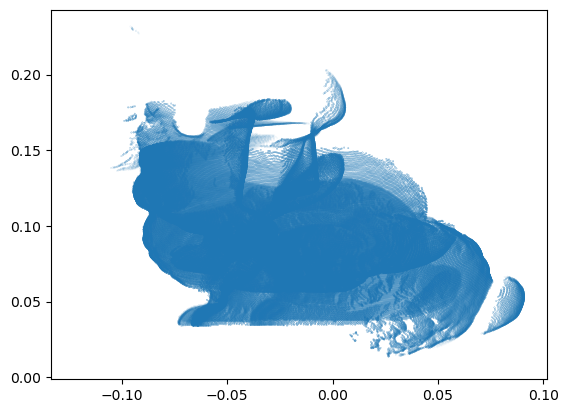

In [131]:
plt.scatter(global_model_ICP[:,0], global_model_ICP[:,1], global_model_ICP[:,2])

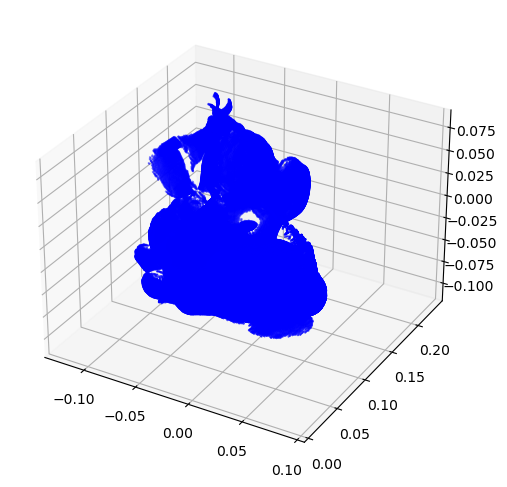

In [132]:
display2([global_model])

In [123]:
global_model_combined = MODEL_dict['bunny_000'].vertices
prior = [None, 90, 180, 270, 315]
for idx, key in tqdm(enumerate(MODEL_dict)):
    if idx == 3:
        continue
    print(key)
    model = MODEL_dict[key].vertices
    if idx == 0:
        global_model_combined = model
        continue

    trans_pred_tmp, R_tmp, t_tmp = apply_DeepVCP(model, global_model_combined, prior[idx-1])
    trans_init = trans_pred_tmp

    src_pcd = o3d.geometry.PointCloud()
    src_pcd.points = o3d.utility.Vector3dVector(model)
    target_pcd = o3d.geometry.PointCloud()
    target_pcd.points = o3d.utility.Vector3dVector(global_model_combined)
    
    reg_p2p_tmp = o3d.pipelines.registration.registration_icp(
        src_pcd, target_pcd, 100, trans_init,
        o3d.pipelines.registration.TransformationEstimationPointToPoint())
    trans = reg_p2p_tmp.transformation
    R_tmp = trans[:3, :3]
    t_tmp = trans[:3, 3]
    align_model = (R_tmp @ model.T).T + t_tmp
    global_model_combined = np.concatenate((global_model_combined, align_model.squeeze()), axis=0)


0it [00:00, ?it/s]

bunny_000
bunny_045
feature extraction time:  6.534315347671509
src_keypts_idx_unsqueezed:  torch.Size([1, 3, 64])
src_keypts:  torch.Size([1, 64, 3])
Grouping keypoints time:  0.01694321632385254
B:  1
K_topk:  64
nsample:  32
num_feat:  32
get_cat_feat_src time:  0.0
tgt_pts_xyz:  torch.Size([1, 10000, 3])
ref_pts:  torch.Size([1, 10000, 3])
dist_normalize:  torch.Size([1, 32, 13824])
feat_weight_map:  torch.Size([1, 32, 32, 13824])
idx_1_mask:  tensor([[0]])
idx_1_mask_flatten:  tensor([0])
idx_2_mask:  tensor([6216, 3311, 6300,  ..., 2666, 2389, 1586], device='cuda:0')
get_cat_feat_tgt time:  0.09169363975524902


2it [00:13,  6.70s/it]

bunny_090
feature extraction time:  6.338799715042114
src_keypts_idx_unsqueezed:  torch.Size([1, 3, 64])
src_keypts:  torch.Size([1, 64, 3])
Grouping keypoints time:  0.014950037002563477
B:  1
K_topk:  64
nsample:  32
num_feat:  32
get_cat_feat_src time:  0.0009963512420654297
tgt_pts_xyz:  torch.Size([1, 10000, 3])
ref_pts:  torch.Size([1, 10000, 3])
dist_normalize:  torch.Size([1, 32, 13824])
feat_weight_map:  torch.Size([1, 32, 32, 13824])
idx_1_mask:  tensor([[0]])
idx_1_mask_flatten:  tensor([0])
idx_2_mask:  tensor([4076, 4182, 6358,  ..., 6992, 8562, 1171], device='cuda:0')
get_cat_feat_tgt time:  0.08034753799438477


3it [00:26,  9.48s/it]

bunny_270
feature extraction time:  6.365857124328613
src_keypts_idx_unsqueezed:  torch.Size([1, 3, 64])
src_keypts:  torch.Size([1, 64, 3])
Grouping keypoints time:  0.018937110900878906
B:  1
K_topk:  64
nsample:  32
num_feat:  32
get_cat_feat_src time:  0.0
tgt_pts_xyz:  torch.Size([1, 10000, 3])
ref_pts:  torch.Size([1, 10000, 3])
dist_normalize:  torch.Size([1, 32, 13824])
feat_weight_map:  torch.Size([1, 32, 32, 13824])
idx_1_mask:  tensor([[0]])
idx_1_mask_flatten:  tensor([0])
idx_2_mask:  tensor([9665, 8577, 7203,  ..., 7649, 1430, 9296], device='cuda:0')
get_cat_feat_tgt time:  0.07873702049255371


5it [00:42,  8.50s/it]

bunny_315
feature extraction time:  6.82915997505188
src_keypts_idx_unsqueezed:  torch.Size([1, 3, 64])
src_keypts:  torch.Size([1, 64, 3])
Grouping keypoints time:  0.01793980598449707
B:  1
K_topk:  64
nsample:  32
num_feat:  32
get_cat_feat_src time:  0.0
tgt_pts_xyz:  torch.Size([1, 10000, 3])
ref_pts:  torch.Size([1, 10000, 3])
dist_normalize:  torch.Size([1, 32, 13824])
feat_weight_map:  torch.Size([1, 32, 32, 13824])
idx_1_mask:  tensor([[0]])
idx_1_mask_flatten:  tensor([0])
idx_2_mask:  tensor([2021, 6984,  134,  ..., 9635, 1650,  877], device='cuda:0')
get_cat_feat_tgt time:  0.08571362495422363


6it [00:55,  9.31s/it]


c:\Users\bingwang\.conda\envs\3D2\lib\site-packages\matplotlib\collections.py:981: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


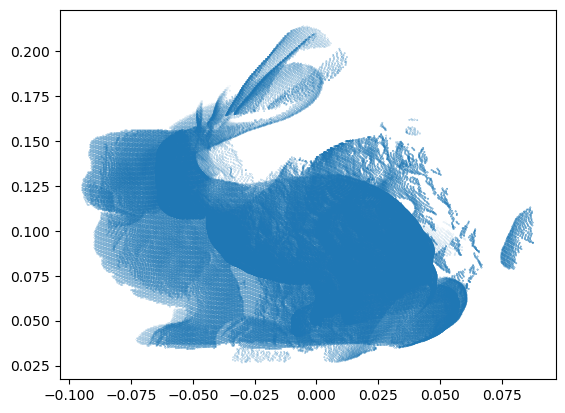

In [124]:
plt.scatter(global_model_combined[:,0], global_model_combined[:,1], global_model_combined[:,2])

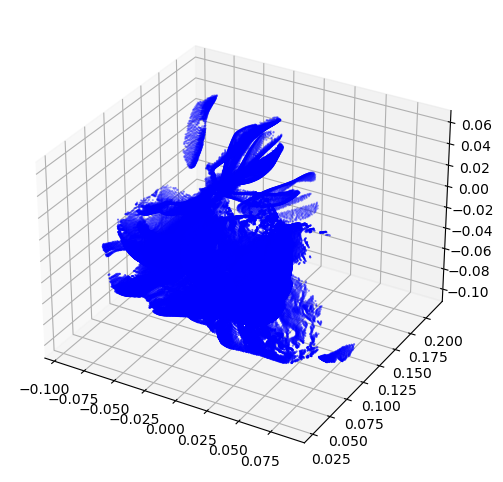

In [125]:
display2([global_model_combined])

In [140]:
global_model_combined_pcd = o3d.geometry.PointCloud()
global_model_combined_pcd.points = o3d.utility.Vector3dVector(global_model_combined)

In [ ]:
o3d.visualization.draw_geometries([global_model_combined_pcd])

## 4. Add gaussian noise

In [ ]:
def add_noise(model, noise_rate):
    x_len = np.amax(model[:,0]) - np.amin(model[:,0])
    y_len = np.amax(model[:,1]) - np.amin(model[:,1])
    z_len = np.amax(model[:,2]) - np.amin(model[:,2])
    diag_len_bounding_box = np.sqrt(x_len * x_len + y_len * y_len + z_len * z_len)
    # Add noise
    std = noise_rate * diag_len_bounding_box
    noise_model = model + np.random.normal(0, std, model.shape)
    return noise_model